In [156]:
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans

df=pd.read_csv("social_marketing.csv")
df.rename(columns={df.columns[0]: 'identifier'}, inplace=True)

df.head()

,identifier,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,hmjoe4g3k,2,0,2,2,2,1,1,0,4,...,1,0,1,1,0,11,0,0,0,0
1,clk1m5w8s,3,3,2,1,1,1,4,1,2,...,0,0,0,1,4,0,0,0,0,0
2,jcsovtak3,6,3,4,3,1,5,0,2,1,...,0,1,0,1,0,0,1,0,0,0
3,3oeb4hiln,1,5,2,2,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,fd75x1vgk,5,2,0,6,1,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0


In [160]:
from sklearn.preprocessing import StandardScaler
    
# Drop any unnecessary columns (e.g., 'uncategorized', 'spam', 'adult' if not needed)
df = df.drop(columns=['uncategorized', 'spam', 'adult','chatter'], errors='ignore')

# Calculate the total number of tweets for each user
df['total_tweets'] = df.iloc[:, 1:].sum(axis=1)

# Normalize the tweet counts horizontally
normalized_df = df.iloc[:, 1:].div(df['total_tweets'], axis=0)

# Drop the 'total_tweets' column as it's no longer needed
normalized_df = normalized_df.drop(columns=['total_tweets'])

# Now apply standard scaling
scaler = StandardScaler()
scaled_df = scaler.fit_transform(normalized_df)  # Assuming the first column is user ID
scaled_df = pd.DataFrame(scaled_df, columns=normalized_df.columns)


#### Horizontally normalizing this data since each user might have different number of tweets (by didviding the number of tweeets in a particular category by the total number of tweeets by that person); 

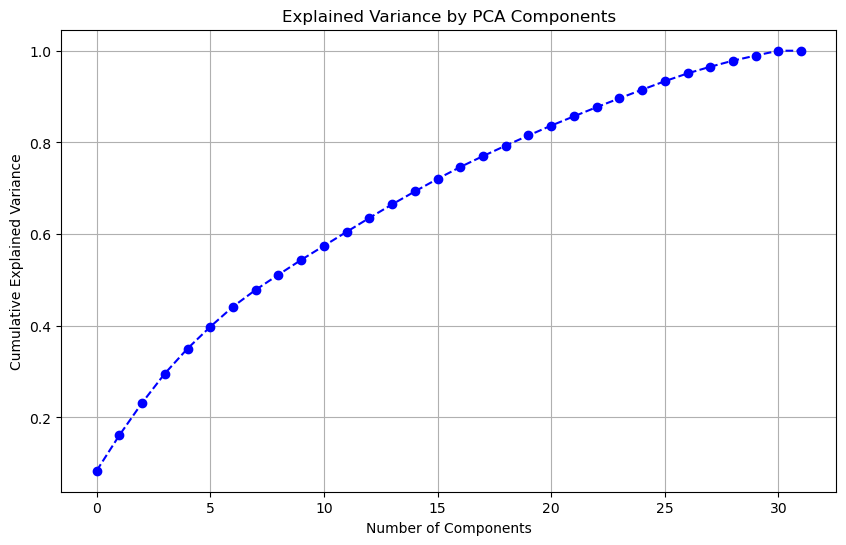

In [163]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_df)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()


#### Stopping  at 5 principal components since sufficient variability is explained and for the convenience of market segmentation

In [165]:

loadings = pd.DataFrame(pca.components_[:5].T, columns=[f'PC{i+1}' for i in range(5)], index=scaled_df.columns)

# Sort contributions for each principal component in descending order
sorted_loadings = loadings.abs().sort_values(by='PC1', ascending=False)

# Display the loadings for the first few components
print(sorted_loadings)

                       PC1       PC2       PC3       PC4       PC5
sports_fandom     0.396591  0.137913  0.030325  0.006368  0.031340
religion          0.389976  0.213727  0.117954  0.039640  0.015415
parenting         0.365453  0.207789  0.079469  0.001494  0.015878
cooking           0.289814  0.183482  0.249364  0.230350  0.270208
health_nutrition  0.271323  0.388638  0.277730  0.102125  0.105376
food              0.270494  0.248111  0.000933  0.104731  0.025742
personal_fitness  0.251351  0.366207  0.265595  0.097014  0.131813
school            0.245225  0.135408  0.152566  0.051277  0.014815
family            0.235397  0.053592  0.065541  0.012385  0.062739
fashion           0.189781  0.077235  0.344478  0.247472  0.287053
outdoors          0.162690  0.261410  0.262047  0.051425  0.000107
photo_sharing     0.118200  0.158910  0.226907  0.197078  0.340017
automotive        0.116974  0.135691  0.167801  0.138073  0.097931
news              0.110789  0.150667  0.328229  0.170472  0.25

#### We have chosen to limit our Principal Components to 5 based on the previous graph since enough variability is being explained by these PCs. Looking at the data of the individual predictors we can conclude that PC1 attributes to individuals interested in food, religion and parenting, so this PC could be capturing interests in 'Adult Parenting'; the 2nd PC captures interestd in health and fitness ; the 3rd prinicpal component  Ccorresponds to interest in Computers and Politics; the 4th PC could be capturing young college going students

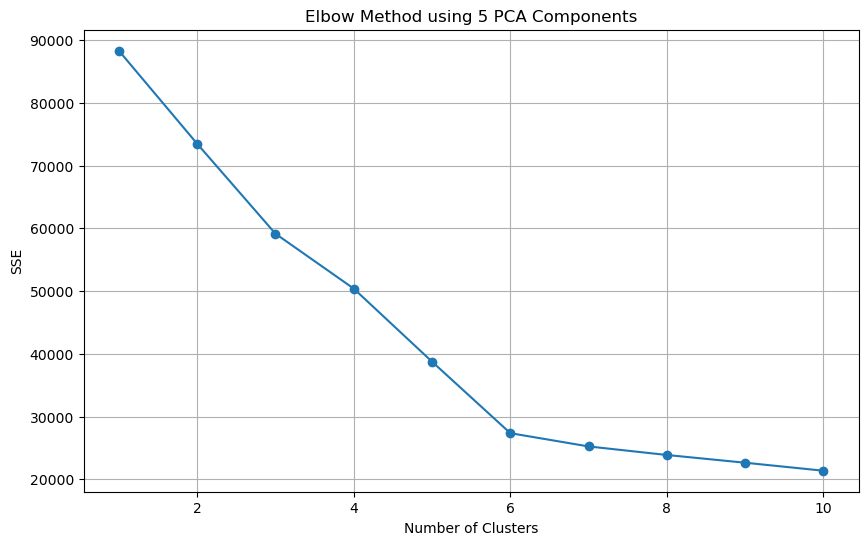

In [168]:
pca = PCA(n_components=5)  # Reduce the dimensionality to 5 components
pca_result = pca.fit_transform(scaled_df)

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(5)])
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method using 5 PCA Components')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

### Optimal Number of clusters in 6 in Kmeans

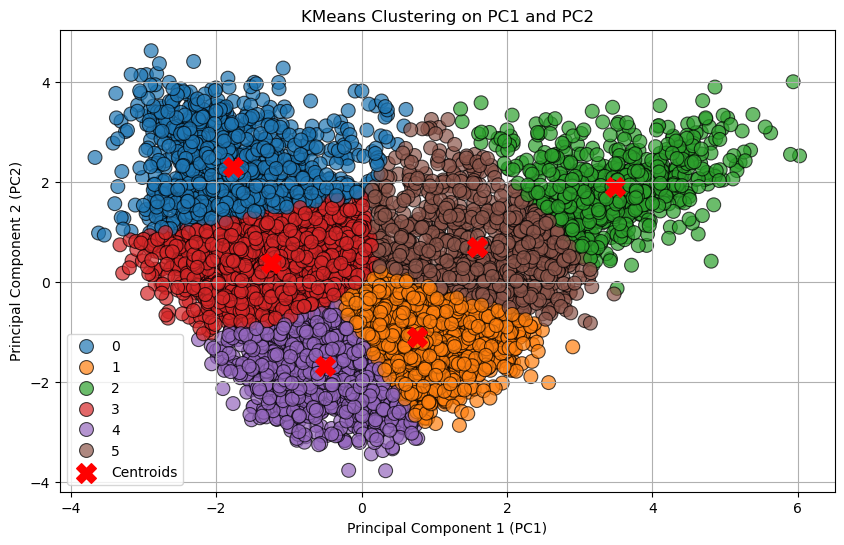

In [179]:
# Apply KMeans clustering with 6 clusters on the first two principal components
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Add the cluster labels to the PCA DataFrame
pca_df['Cluster'] = clusters
df['Cluster']=clusters

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='tab10', data=pca_df, s=100, alpha=0.7, edgecolor='k')

# Mark the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')

plt.title('KMeans Clustering on PC1 and PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()


In [181]:
cluster_means = df.iloc[:,1:].groupby('Cluster').mean()
cluster_means

,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,music,...,art,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,total_tweets
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1.330357,0.935714,2.232143,0.635714,0.953571,0.723214,1.761607,0.623214,0.513393,0.606250,...,0.499107,0.651786,0.833036,0.660714,0.816964,0.525000,5.210714,1.266071,0.211607,85.760714
1,1.516799,2.077581,2.127673,1.210141,1.568112,3.241295,1.002443,0.829566,0.490531,0.599267,...,0.739768,0.716555,0.302993,0.676237,0.630422,0.609041,0.377520,0.367746,0.350641,60.983506
2,1.360681,0.922601,1.411765,0.608359,5.173375,0.682663,4.058824,2.185759,0.498452,0.490712,...,0.472136,4.688854,0.750774,3.571207,0.417957,2.334365,0.736842,0.609907,0.256966,79.018576
3,1.563692,1.389538,3.714462,1.032615,0.865846,1.344000,0.915692,0.675077,0.542769,0.825231,...,0.752615,0.507692,1.461538,0.494769,1.004308,0.649846,1.827692,2.218462,0.358769,78.905846
4,1.655155,2.063918,3.159278,1.432474,0.602577,2.099485,0.560309,0.493814,0.527835,0.747938,...,0.907216,0.275773,0.301546,0.221649,0.497423,0.285052,0.401031,0.567010,0.408763,60.917526
5,1.560175,1.297593,2.402626,0.977024,3.294311,1.404814,2.411379,1.407002,0.544858,0.640044,...,0.716630,2.562363,0.748359,2.050328,0.863239,1.475930,0.925602,0.805252,0.326039,76.210066


In [183]:
cluster_means.drop(['total_tweets'],axis=1,inplace=True)

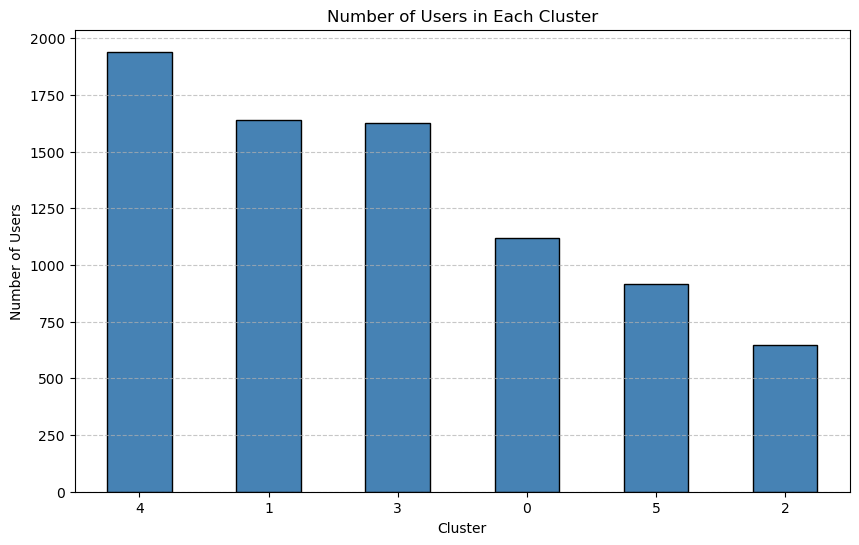

In [185]:
cluster_counts = df['Cluster'].value_counts()

# Plot the number of users in each cluster
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='steelblue', edgecolor='black')

plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Cluster')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [187]:
top3_per_cluster = cluster_means.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

# Convert the results to a DataFrame for better readability
top3_df = pd.DataFrame(top3_per_cluster.tolist(), index=top3_per_cluster.index, columns=['Top_1', 'Top_2', 'Top_3'])

print(top3_df)

                    Top_1             Top_2             Top_3
Cluster                                                      
0        health_nutrition  personal_fitness           cooking
1                politics              news     photo_sharing
2           sports_fandom          religion              food
3                 cooking     photo_sharing  health_nutrition
4           photo_sharing       college_uni     online_gaming
5           sports_fandom          religion              food


#### Here are the six market segments identified:
- Social Gamers: Predominantly interested in online gaming, photo sharing, and college/university-related content.
- Trendy Cooks: Focused on cooking, photo sharing, and fashion.
- Engaged Shoppers: Emphasize photo sharing, shopping, and current events.
- Sports and Food Enthusiasts: Interested in sports fandom, religion, and food.
- News and Politics Followers: Focus on politics, news, and travel.
- Health and Fitness Buffs: Prioritize health and nutrition, personal fitness, and cooking.

 Each segment reveals unique preferences that can inform targeted marketing strategies. By aligning content with these interests, NutrientH20 can enhance engagement and tailor its social media campaigns more effectively. 

#### Allocation of resources: We have also plotted of graph of number of users in each cluster above. NutrienH20 can use this data to plan their marketing strategy and allocation of resources accordingly